## Credits
A) John

B and C) Jared

## Problem 7.2: MCMC with Boolean data (40 pts)

In [Homework 6](hw6.html), you investigated a data set on reversals of optogenetic worms upon exposure to blue light. As a reminder, here are the data.

|Strain|Year|Trials|Reversals|
|:---:|:---:|:---:|:---:|
|WT|2017|55|7|
|ASH|2017|54|18|
|AVA|2017|52|28|
|WT|2016|36|6|
|ASH|2016|35|12|
|AVA|2016|36|30|
|WT|2015|35|0|
|ASH|2015|35|9|
|AVA|2015|36|33|

Again, for the purposes of this problem, assume that we can pool the results from the two years to have 13/126 reversals for wild type, 39/124 reversals for ASH, and 91/124 reversals for AVA.

The pertinent parameter is $\theta$, the probability of reversal of a worm upon illumination.

**a)** Use Stan to get samples of $\theta$ for each of the three strains. Plot either histograms or ECDFs of your samples.

In [1]:
import bebi103
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
import numpy as np
import pandas as pd
import numba
import scipy.stats as st
# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat
alt.data_transformers.enable('json')

Loading BokehJS ...

DataTransformerRegistry.enable('json')

## Prior predictive check
I wrote the stan prior-predictive model, and I'll show it here. Again, we are modeling the number of reversals as a binomial distribution, such that the probability of reversal has a beta-distributed prior. The parameters of the beta distribution are different for each strain of worm. 

In [2]:
sm = bebi103.stan.StanModel(file='./7.2_prior_pred.stan')
print(sm.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_39cad81e2e244e6a8607698349c92b78 NOW.
/Users/john/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/y1/8dl7vbx177x_5494bppvvk5w0000gn/T/tmpmuuzwwr3/stanfit4anon_model_39cad81e2e244e6a8607698349c92b78_4405095477232375342.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


data{
    int N;
    real alpha[N];
    real beta_[N];
    int trials[N];
}

generated quantities{
    // Parameters
    real theta[N];
    real rev_prob[N];
    for (i in 1:N) {
        theta[i] = beta_rng(alpha[i], beta_[i]);
    }

    // Data
    for (i in 1:N) {
        rev_prob[i] = binomial_rng(trials[i], theta[i]) / trials[i];
    }
}


I will pass this generative model the parameters of the experiment and generate data. 

In [3]:
# arrays for alpha and beta values for our three strains
a_array = [1, 2, 5]
b_array = [8, 7, 6]

# arrays for the datapoints we have for number of reversals for our three strains
n_array = [13, 39, 91]
N_array = [126, 124, 124]

# Store input parameters in a dictionary so stan can access them
data = dict(N=3,
            alpha = a_array,
            beta_ = b_array,
            trials = N_array)

# Generate samples
samples_gen = sm.sampling(data=data,
                          algorithm='Fixed_param',
                          warmup=0,
                          chains=1,
                          iter=1000)
# Store samples in a dataframe
df_gen = bebi103.stan.to_dataframe(samples_gen, diagnostics=False)
df_gen.head()

,chain,chain_idx,warmup,theta[1],theta[2],theta[3],rev_prob[1],rev_prob[2],rev_prob[3],lp__
0,1,1,0,0.034604,0.191166,0.536185,0.0,0.0,0.0,0.0
1,1,2,0,0.055555,0.146952,0.341809,0.0,0.0,0.0,0.0
2,1,3,0,0.024363,0.107298,0.279194,0.0,0.0,0.0,0.0
3,1,4,0,0.045065,0.083576,0.582936,0.0,0.0,0.0,0.0
4,1,5,0,0.121397,0.035916,0.534195,0.0,0.0,0.0,0.0


It looks like the sampling worked well. Let's plot the distribution for each theta.

In [4]:
def show_ecdf(n, name, color, p):
    return bebi103.viz.ecdf(n, 
                            color = color,
                            legend= name,
                            alpha=1, 
                            line_alpha=0,
                            p=p)
p = bokeh.plotting.Figure(x_axis_label='probability of reversal')
p = show_ecdf(df_gen["theta[1]"].values, "WT", "blue", p)
p = show_ecdf(df_gen["theta[2]"].values, "ASH", "red", p)
p = show_ecdf(df_gen["theta[3]"].values, "AVA", "black", p)
p.legend.location = "bottom_right" 
bokeh.io.show(p)

This prior-predictive check makes perfect sense. We expect most wildtype reversal probabilities to be very low, and ASH and AVA probabilities to each be higher than one another. I will now write models to perform sampling from the posterior. 

In [5]:
sm_mcmc_wt = bebi103.stan.StanModel(file='./7.2_mcmc_wt.stan')
sm_mcmc_ash = bebi103.stan.StanModel(file='./7.2_mcmc_ash.stan')
sm_mcmc_ava = bebi103.stan.StanModel(file='./7.2_mcmc_ava.stan')
print("-------------WT MODEL-------------")
print(sm_mcmc_wt.model_code)
print("-------------ASH MODEL-------------")
print(sm_mcmc_ash.model_code)
print("-------------AVA MODEL-------------")
print(sm_mcmc_ava.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e0f11671e19d583190fe389c1afad791 NOW.
/Users/john/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/y1/8dl7vbx177x_5494bppvvk5w0000gn/T/tmpbhq8aidu/stanfit4anon_model_e0f11671e19d583190fe389c1afad791_3779793561681110556.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_60d9a9728c470832d76b493405215dd9 NOW.
/Users/john/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/y1/8dl7vbx177x_5494bppvvk5w0000gn/T/tmph5caiwhl/stanfit4anon_model_60d9a9728c470832d76b493405215dd9_6714554952611393301.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:pystan:COMPILING THE C+

-------------WT MODEL-------------
data{
    int N;
    int WT;
    int trials;
}

parameters{
    real theta;
}

model{
    // Priors
    theta ~ beta(1.0, 8.0);

    // Likelihood
    WT ~ binomial(trials, theta);
}
-------------ASH MODEL-------------
data{
    int N;
    int ASH;
    int trials;
}

parameters{
    real theta;
}

model{
    // Priors
    theta ~ beta(2.0, 7.0);

    // Likelihood
    ASH ~ binomial(trials, theta);
}
-------------AVA MODEL-------------
data{
    int N;
    int AVA;
    int trials;
}

parameters{
    real theta;
}

model{
    // Priors
    theta ~ beta(5.0, 6.0);

    // Likelihood
    AVA ~ binomial(trials, theta);
}


I will start by sampling from the posterior for the wildtype species. 

In [6]:
data_wt =  dict(N = 3,
                WT = 13,
                trials = N_array[0])
data_ash = dict(N = 3,
                ASH = 39, 
                trials = N_array[1])
data_ava = dict(N = 3, 
                AVA = 91,
                trials = N_array[2])
samples_wt = sm_mcmc_wt.sampling(data=data_wt)
df_mcmc_wt = bebi103.stan.to_dataframe(samples_wt, diagnostics=False)
df_mcmc_wt.head()

,chain,chain_idx,warmup,theta,lp__
0,1,1,0,0.123597,-43.010979
1,1,2,0,0.131468,-43.291012
2,1,3,0,0.041447,-46.463048
3,1,4,0,0.041447,-46.463048
4,1,5,0,0.046468,-45.606767


Now I need to repeat sampling for the other two strains. 

In [7]:
samples_ash = sm_mcmc_ash.sampling(data=data_ash)
df_mcmc_ash = bebi103.stan.to_dataframe(samples_ash, diagnostics=False)
df_mcmc_ash.head()

,chain,chain_idx,warmup,theta,lp__
0,1,1,0,0.350174,-81.198614
1,1,2,0,0.337967,-80.924304
2,1,3,0,0.313725,-80.628933
3,1,4,0,0.291540,-80.667339
4,1,5,0,0.280642,-80.802067


In [8]:
samples_ava = sm_mcmc_ava.sampling(data=data_ava)
df_mcmc_ava = bebi103.stan.to_dataframe(samples_ava, diagnostics=False)
df_mcmc_ava.head()

,chain,chain_idx,warmup,theta,lp__
0,1,1,0,0.734520,-79.707313
1,1,2,0,0.736959,-79.743106
2,1,3,0,0.752817,-80.083441
3,1,4,0,0.784090,-81.356948
4,1,5,0,0.775798,-80.934887


Now I can plot my samples from the posterior!

In [9]:
p = bokeh.plotting.Figure(x_axis_label='probability of reversal')
p = show_ecdf(df_mcmc_wt["theta"].values, "WT", "blue", p)
p = show_ecdf(df_mcmc_ash["theta"].values, "ASH", "red", p)
p = show_ecdf(df_mcmc_ava["theta"].values, "AVA", "black", p)
p.legend.location = "bottom_right" 
bokeh.io.show(p)

**b)** Use your Metropolis-Hastings sampler from the previous problem to do the same.


First I'm going to include all the functions we made in the previous problem. We explained this code previously, so I'm not going to explain it here.

In [10]:
def mh_step(x, logpost, logpost_current, sigma, args=()):
    """
    Parameters
    ----------
    x : ndarray, shape (n_variables,)
        The present location of the walker in parameter space.
    logpost : function
        The function to compute the log posterior. It has call
        signature `logpost(x, *args)`.
    logpost_current : float
        The current value of the log posterior.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    args : tuple
        Additional arguments passed to `logpost()` function.

    Returns
    -------
    output : ndarray, shape (n_variables,)
        The position of the walker after the Metropolis-Hastings
        step. If no step is taken, returns the inputted `x`.
    """
    # Turn sigma into a diagonal matrix so that it can be used as
    # the covariance matrix for numpy's multivariate guassian function
    cov = np.diag(sigma * sigma) # squared because variance is std. squared
    
    # Now I will choose the next step, x-prime
    xp = np.random.multivariate_normal(x, cov, 1)[0]
    
    # Compute the log-posterior at x-prime
    logpost_xp = logpost(xp, *args)
    
    # Calculate metropolis ratio
    r = np.exp(logpost_xp - logpost_current)
    
    if (r >= 1):
        return xp
    elif(np.random.rand() < r):
        return xp
    else:
        return x

In [11]:
def calc_acceptance_rate(output_df):
    """Determines the acceptance rate of an MCMC sampler within the passed
    dataframe containing MCMC samples. """
    num_rejections = 0
    last_row = np.zeros(len(output_df.loc[0].values))
    for row in output_df.iterrows():
        row = row[1].values
        if (row == last_row).all():
            num_rejections += 1
        last_row = row
    return (len(output_df.index) - num_rejections) / len(output_df.index)

In [12]:
def find_std_dev_correction(acceptance_rate):
    """Returns the necessary multiplicative correction to the standard deviation
    of the proposal distribution given an acceptance rate for the metropolis-
    hastings MCMC sampler. """
    if acceptance_rate < .001:
        return 0.1
    elif acceptance_rate < 0.05:
        return 0.5
    elif acceptance_rate < 0.2:
        return 0.9
    elif acceptance_rate < 0.5:
        return 1
    elif acceptance_rate < 0.75:
        return 1.1
    elif acceptance_rate < 0.95:
        return 2
    else:
        return 10

In [13]:
def mh_sample_optimize_acceptance(logpost, 
                                  x0, 
                                  sigma, 
                                  args=(), 
                                  n_burn=1000, 
                                  n_steps=1000, 
                                  n_opt_acc = 1000,
                                  variable_names=None):
    """New sampling function that includes optimization of sigma
    with respect to the acceptance rate. n_opt_acc indicates the number
    of steps that should be used to optimize, but all other parameters
    are identical to those used in mh_sample()"""
    
    # Define variable names
    if variable_names == None:
        variable_names = list(range(len(x0)))
    
    # Define starting points
    x = x0
    logpost_current = logpost(x, *args)
        
    # Burn step    
    for c in range(n_burn):
        x = mh_step(x, logpost, logpost_current, sigma, args=args)
        logpost_current = logpost(x, *args)
    
    # Starting optimization!!
    iterations = 0
    while(True):
        # Make arrays to take optimization data
        samples_opt = [0]*n_opt_acc
        logpost_values_opt = np.empty([len(range(n_opt_acc))])

        # Do the sampling
        for k in range(n_opt_acc):
            x = mh_step(x, logpost, logpost_current, sigma, args=args)
            logpost_current = logpost(x, *args)
            samples_opt[k] = x
            logpost_values_opt[k] = logpost_current

        # Convert arrays to dataframe    
        df_opt =  pd.DataFrame(data=samples_opt, columns = variable_names)
        df_opt["lnprob"] = logpost_values_opt
        
        # Calculate acceptance rate and optimize sigma
        rate = calc_acceptance_rate(df_opt)
        opt_factor = find_std_dev_correction(rate)
        sigma *= opt_factor
        
        # If the acceptance rate was way off, repeat this process again. 
        # Otherwise, we can exit the loop
        if (opt_factor == 1):
            break
            
        # This program has the potential for an infinite loop. I don't want
        # this to happen, so if this iterates 10 times I'll print a warning
        # statement and stop optimizing. 
        iterations += 1
        if iterations >= 10:
            print("WARNING: Acceptance rate did not converge!")
            break
    
    # Make arrays to take data
    samples = [0]*n_steps
    logpost_values = np.empty([len(range(n_steps))])
    
    # Do the sampling
    for k in range(n_steps):
        x = mh_step(x, logpost, logpost_current, sigma, args=args)
        logpost_current = logpost(x, *args)
        samples[k] = x
        logpost_values[k] = logpost_current
        
    
    # Convert arrays to dataframe    
    df =  pd.DataFrame(data=samples, columns = variable_names)
    df["lnprob"] = logpost_values

    return df

First we need to input our data and models into arrays, which we did last week for this same problem. Using the same model we used last week:

In [14]:
# arrays for alpha and beta values for our three strains
a_array = [1, 2, 5]
b_array = [8, 7, 6]

# arrays for the datapoints we have for number of reversals for our three strains
n_array = [13, 39, 91]
N_array = [126, 124, 124]
# array for the names of the conditions
name_array = ['WT', 'ASH', 'AVA']

Next we need to define a log post function that fits our model as we defined it last week:

In [15]:
def log_post_reversal(x, a, b, n, N):
    # Priors are beta distributions, different for each condition
    log_prior = st.beta.logpdf(x, a, b)

    # The log_likelihood is just the binomial distribution
    log_like = np.sum(st.binom.logpmf(n, N, x))

    return log_prior + log_like

Finally, let's run the sampler for each of the three conditions and plot the result:

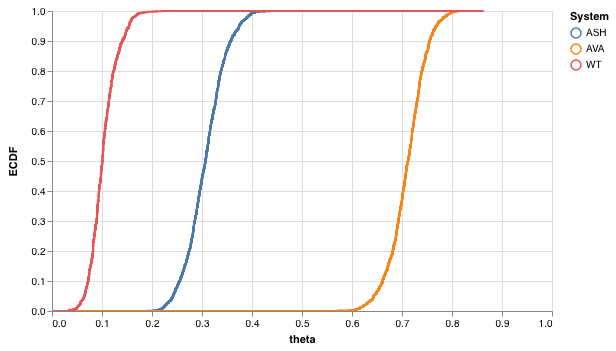

In [16]:
# Initial guess for MCMC
x_0 =np.array([1])
# Standard Deviations for proposal dist.
s = np.array([1.])

# Sample the three conditions
for i in range(3):
    df_mcmc_temp = mh_sample_optimize_acceptance(log_post_reversal, 
                         x_0, 
                         s, 
                         args = (a_array[i], b_array[i], n_array[i], N_array[i]),
                         n_steps=5000,
                         variable_names = ["theta"])
    df_mcmc_temp["Condition"] = name_array[i]
    if i == 0:
        df_mcmc_total = df_mcmc_temp
    else:
        df_mcmc_total = pd.concat([df_mcmc_total, df_mcmc_temp])

# Plot
altcat.catplot(data=df_mcmc_total,
               mark='line',
               encoding=dict(x=alt.X('theta:Q',
                                     scale=alt.Scale(
                                     domain=(0, 1),
                                     clamp=True)),
                            color = alt.Color('Condition:N', title='System')),
               transform='ecdf'
              ).properties(height=300,
                           width=500)

This looks just like how we'd expect!


**c)** The posterior plots of $\theta$ are illuminating, but suppose we want to quantify *the difference* in reversal probability between the two strains, say strain 1 and strain 2. That is, we want to compute $g(\delta_{12}\mid n_1, N_1, n_2, N_2)$, where $\delta_{12} \equiv \theta_2 - \theta_1$. Note that computing this distribution by hand is quite difficult.

To quantify this difference we can simply take the difference between the two distributions. To do this I will first get samples for theta for each of the three conditions in one dataframe:

In [17]:
# Initial guess for MCMC
x_0 =np.array([1])
# Standard Deviations for proposal dist.
s = np.array([1.])

for i in range(3):
    df_mcmc_temp = mh_sample_optimize_acceptance(log_post_reversal, 
                         x_0, 
                         s, 
                         args = (a_array[i], b_array[i], n_array[i], N_array[i]),
                         n_steps=5000,
                         variable_names = [name_array[i]])
    if i == 0:
        df_mcmc_total2 = df_mcmc_temp
    else:
        df_mcmc_total2[name_array[i]] = df_mcmc_temp[name_array[i]]

Next we will use dataframe methods to compute the difference between the thetas each two of the three strains.

In [18]:
df_mcmc_total2["ASH-WT"]= df_mcmc_total2["ASH"] - df_mcmc_total2["WT"]
df_mcmc_total2["AVA-WT"]= df_mcmc_total2["AVA"] - df_mcmc_total2["WT"]
df_mcmc_total2["AVA-ASH"]= df_mcmc_total2["AVA"] - df_mcmc_total2["ASH"]
df_mcmc_total2.head()

,WT,lnprob,ASH,AVA,ASH-WT,AVA-WT,AVA-ASH
0,0.051531,-3.142844,0.264379,0.724045,0.212848,0.672514,0.459666
1,0.148188,-2.308950,0.292216,0.724045,0.144028,0.575857,0.431829
2,0.148188,-2.308950,0.317458,0.724045,0.169270,0.575857,0.406587
3,0.148188,-2.308950,0.317458,0.724045,0.169270,0.575857,0.406587
4,0.148188,-2.308950,0.317458,0.724045,0.169270,0.575857,0.406587


To make this easier to plot I will now tidy the dataframe:

In [19]:
df_mcmc_total2 = df_mcmc_total2.drop(['lnprob', 'WT','ASH','AVA'], axis = 1)
df_mcmc_total2_tidy = df_mcmc_total2.stack(level=0)
df_mcmc_total2_tidy = df_mcmc_total2_tidy.sort_index(level=1)
df_mcmc_total2_tidy = df_mcmc_total2_tidy.reset_index(level=1)
df_mcmc_total2_tidy = df_mcmc_total2_tidy.rename(columns={'level_1': 'Condition', 
                                                          0:'delta'})
df_mcmc_total2_tidy.head()

,Condition,delta
0,ASH-WT,0.212848
1,ASH-WT,0.144028
2,ASH-WT,0.169270
3,ASH-WT,0.169270
4,ASH-WT,0.169270


And plot!

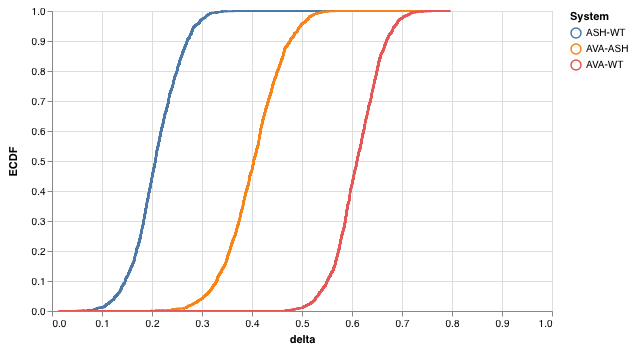

In [20]:
altcat.catplot(data=df_mcmc_total2_tidy,
               mark='line',
               encoding=dict(x=alt.X('delta:Q',
                                     scale=alt.Scale(
                                     domain=(0, 1),
                                     clamp=True)),
                            color = alt.Color('Condition:N', title='System')),
               transform='ecdf'
              ).properties(height=300,
                           width=500)

Once again, this looks great! Unsurprisingly, the difference is smallest between the two lowest probability strains, and highest between the lowest and highest probability strains.